In [1]:
%pylab inline
import jax
import jax.numpy as np
import numpy as onp
import flax
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

In [3]:
# Load the data
parameters_raw = pd.read_hdf('dalek-2020-06-02/data/grid1_v2_log_uniform_params_16feb20_part1_train_98k.h5')
spectra_raw = onp.load('dalek-2020-06-02/data/grid1_v2_log_uniform_fluxes_16feb20_part1_train_interp_98k.npy')

In [4]:
# We'll normalize the inputs/outputs a bit
from sklearn import preprocessing

parameters_n = parameters_raw.copy()
parameters_n = onp.log10(parameters_n)
parameters_n_min = parameters_n.min(axis=0)
parameters_n_max = parameters_n.max(axis=0)
parameters_n = (parameters_n - parameters_n_min)/(parameters_n_max - parameters_n_min)
parameters_n = parameters_n.values

scaler_parameters = preprocessing.StandardScaler().fit(parameters_n)
n_parameters_n = scaler_parameters.transform(parameters_n)

spectra_n = (spectra_raw - spectra_raw.min())
spectra_n = spectra_n/spectra_n.max()

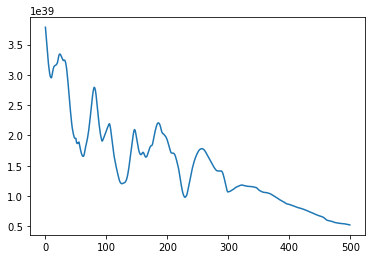

In [5]:
plot(spectra_raw[1,:])

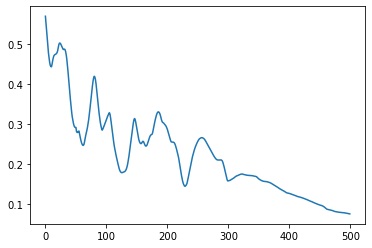

In [6]:
plot(spectra_n[1,:])

In [7]:
batch_size = 128

In [9]:
# Ok, cool, we can define a trivial model which returns the 
# interpolated value
from flax import nn, optim
class emulator(nn.Module):
    
    def apply(self, p):
        
        # Where p are inputs parameters 
        net = nn.leaky_relu(nn.Dense(p, 256))
        net = nn.leaky_relu(nn.Dense(net, 256)) 
        
        vals = nn.Dense(net, 500)
        scale = nn.softplus(nn.Dense(net, 500)) + 1e-2
        
        return vals, scale

In [10]:
# Ok, sweet, let's try it out:
_, initial_params = emulator.init_by_shape(jax.random.PRNGKey(0),
                                           [((batch_size,12), np.float32)])
model = flax.nn.Model(emulator, initial_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [11]:
# Perfect, now....  let's try to learn a spline :-D 

In [12]:
def get_batch():
    """ Simple function that extracts a random batch
    """
    inds = onp.random.choice(len(n_parameters_n), batch_size)
    return {'x': n_parameters_n[inds].astype('float32'),
            'y': spectra_n[inds].astype('float32')}

In [13]:
@jax.jit
def train_step(optimizer,batch):
  def loss_fn(model):
    mu, scale = model(batch['x'])
    # Compute likelihood
    likelihood = tfp.distributions.Normal(mu, scale)
    loss = - likelihood.log_prob(batch['y']).mean() 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer,l 

In [14]:
 # We also need an optimizer
optimizer = flax.optim.Momentum(
      learning_rate=0.001, beta=0.9).create(model)

In [15]:
losses = []

In [16]:
batch = get_batch()

In [ ]:
for i in range(100000):
    # Let's try to learn
    batch = get_batch()
    optimizer, l = train_step(optimizer, batch)
    losses.append(l)
    if i%1000 ==0:
        print(l)

-3.3320115
-3.2568295


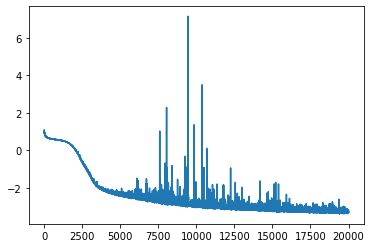

In [37]:
plot((losses))

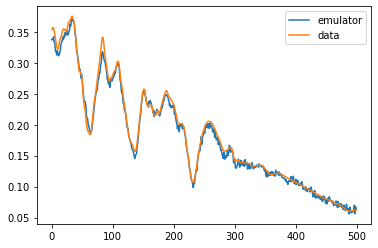

In [38]:
plot(optimizer.target(batch['x'])[0][0], label='emulator')
plot(batch['y'][0], label='data')
legend()

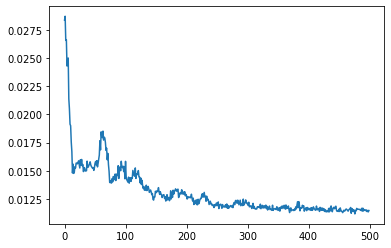

In [39]:
plot(optimizer.target(batch['x'])[1][0], label='emulator')

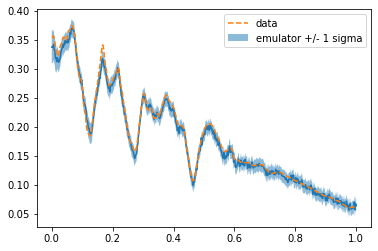

In [40]:
x = np.linspace(0,1.0, 500)
fill_between(x,
             optimizer.target(batch['x'])[0][0] - optimizer.target(batch['x'])[1][0],
             optimizer.target(batch['x'])[0][0] + optimizer.target(batch['x'])[1][0],
             label='emulator +/- 1 sigma', alpha=0.5)
plot(x, optimizer.target(batch['x'])[0][0])
plot(x, batch['y'][0], '--', label='data')
legend()